# Agrupamento hierárquico

Vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv('online_shoppers_intention.csv')

In [13]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [14]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Fizemos uma análise descritiva das variáveis do escopo.

- Verificamos a distribuição dessas variáveis
- Vimos se há valores *missing*
- Fizemos mais alguns tratamento nas variáveis 

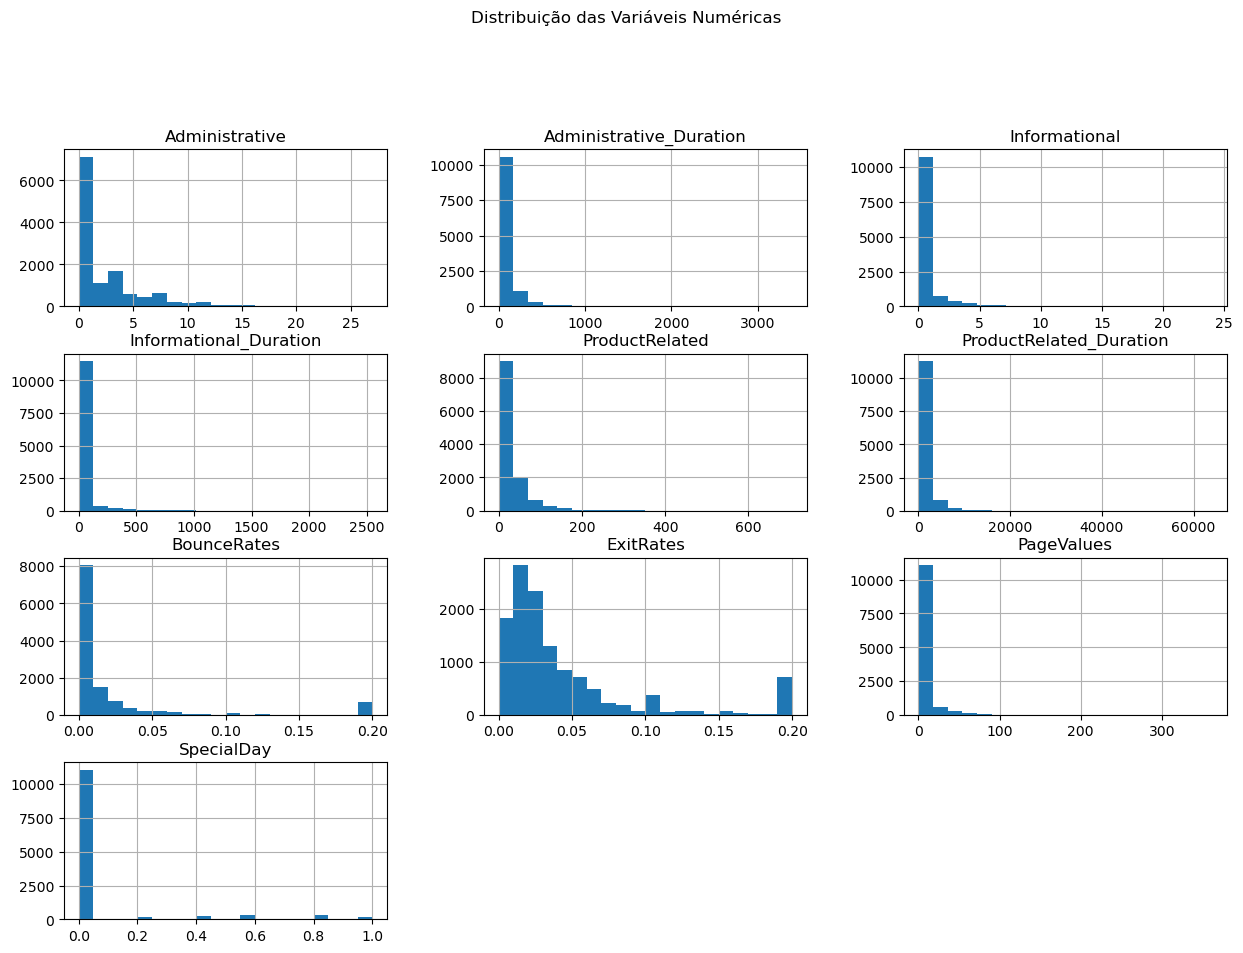

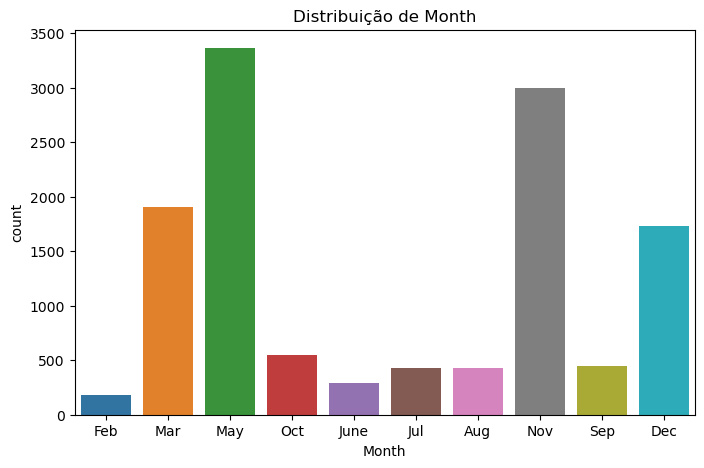

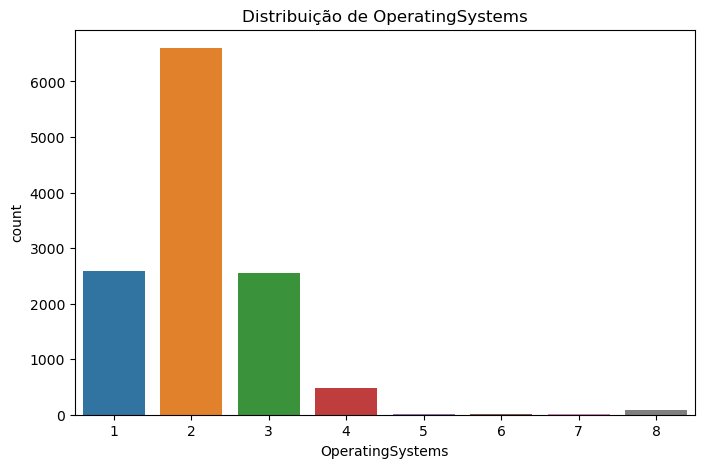

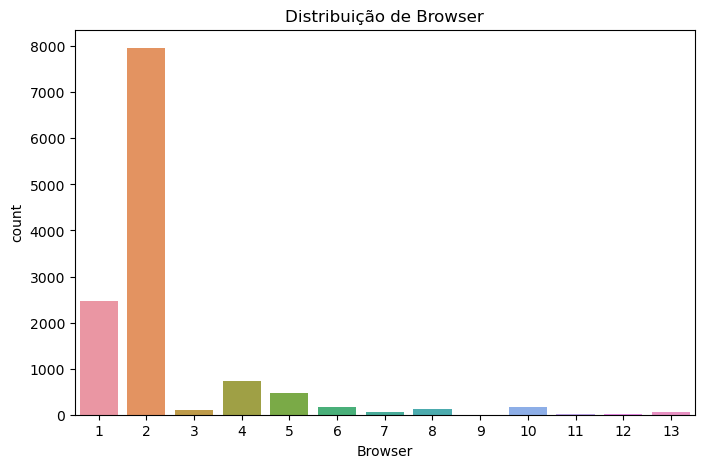

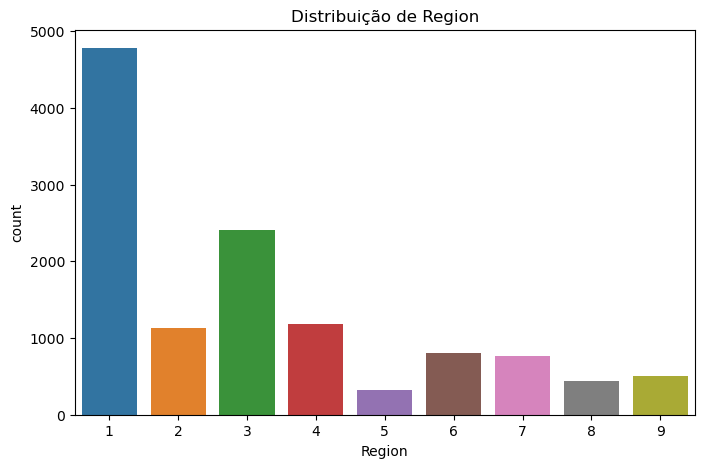

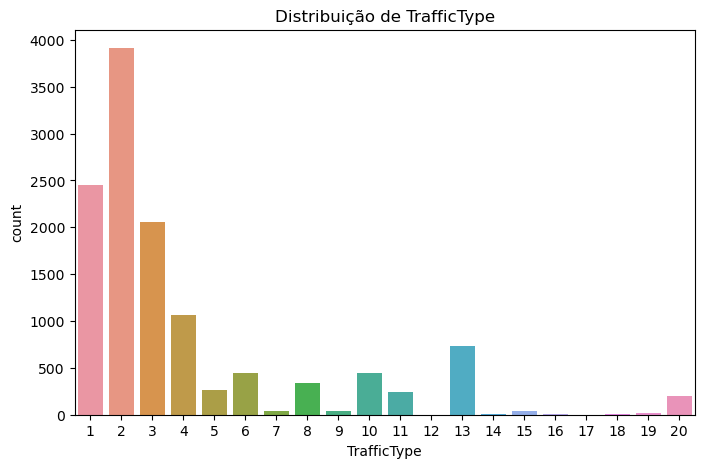

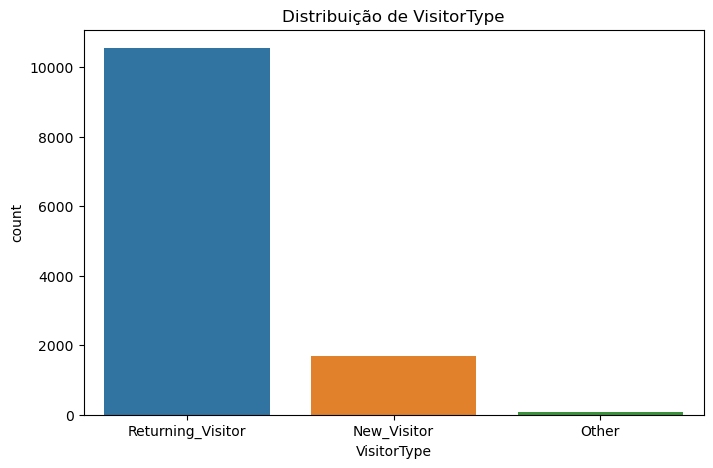

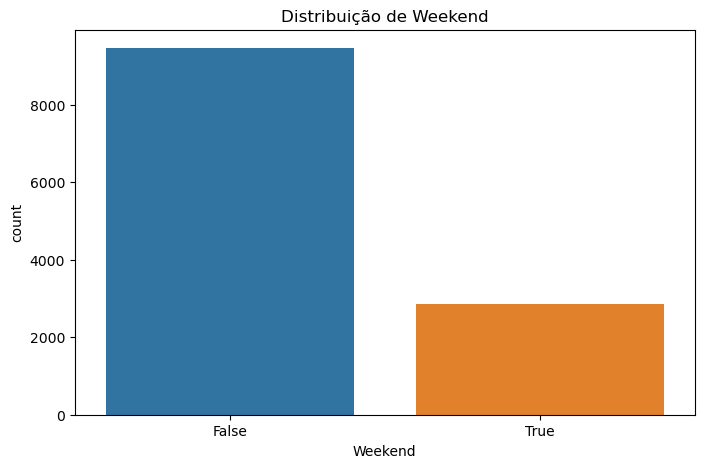

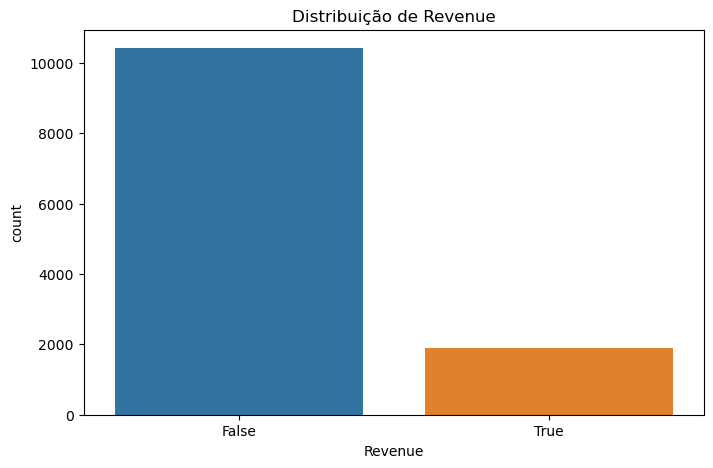

In [15]:
# Visualizar a distribuição das variáveis numéricas
numeric_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                   'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Histogramas para variáveis numéricas
df[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis Numéricas', y=1.02)
plt.show()

# Contagem de valores para variáveis categóricas
categorical_columns = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']

for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribuição de {column}')
    plt.show()

In [18]:
# Verificar valores ausentes
missing_values = df.isnull().sum()

# Exibir as variáveis com valores ausentes, se houver
print("Valores Ausentes:")
print(missing_values[missing_values > 0])

# Excluir linhas com valores ausentes
df.dropna(inplace=True)

# Confirmar que não há mais valores ausentes
print("\nApós a exclusão de valores ausentes:")
print(df.isnull().sum())


Valores Ausentes:
Series([], dtype: int64)

Após a exclusão de valores ausentes:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


## Variáveis de agrupamento

Listamos as variáveis que utilizamos. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecionamos para o agrupamento variáveis que descrevem o padrão de navegação na sessão.
- Selecionamos variáveis que indicam a característica da data.
- Não esquecendo que vamos precisar realizar um tratamento especial para variáveis qualitativas.
- Tratamos adequadamente valores faltantes.

In [37]:
# Selecionar Variáveis
variaveis = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'SpecialDay', 'Month', 'Weekend']
variaveis_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 
                 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']
variaveis_cat = ['SpecialDay', 'Month', 'Weekend']

# Criar DataFrame auxiliar
df_pad = pd.DataFrame()

# Adicionar variáveis quantitativas
df_pad[variaveis_qtd] = df[variaveis_qtd]

# Adicionar variáveis categóricas e criar dummies
df_pad = pd.concat([df_pad, pd.get_dummies(df[variaveis_cat], drop_first=True)], axis=1)

# Verificar o novo DataFrame
df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.000000,0.0,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.0,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.0,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.0,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.0,1,0,1,0,0,0,0,0,0,0


In [38]:
# Lista dos nomes das colunas presentes no DataFrame
df_pad.columns.values

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'SpecialDay', 'Weekend', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep'], dtype=object)

## Número de grupos

Nesta parte vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

In [45]:
%time

# Padronização das variáveis
scaler = StandardScaler()
df_pad_scaled = scaler.fit_transform(df_pad)

# Configura o modelo de clustering hierárquico aglomerativo com linkage "complete", sem limite de distância e 3 clusters
clus = AgglomerativeClustering(linkage="complete", distance_threshold=None, n_clusters=3)

# Ajusta o modelo aos dados padronizados
clus.fit(df_pad_scaled)

# Adiciona a coluna 'grupo' ao DataFrame original 'df'
df['grupo'] = clus.labels_

In [47]:
# Cruza a tabela de hierarquia que criamos com a venda ou nao venda da tabela 'Revenue'
pd.crosstab(df['Revenue'], df['grupo'])

grupo,0,1,2
Revenue,,,
0,10300,3,119
1,1831,0,77


**Grupo 0:** 
* Parece ter uma alta proporção de observações com 'Revenue' igual a 0 (sem compra). Isso sugere que o Grupo 0 pode representar visitantes que geralmente não realizam compras no site.

**Grupo 1:**
* Todas as observações desse grupo têm 'Revenue' igual a 0, o que indica que esse grupo pode ser composto por visitantes que nunca realizam compras no site.

**Grupo 2:**
* Tem uma distribuição mais equilibrada entre 'Revenue' igual a 0 e 1. Isso sugere que o Grupo 2 contém observações de visitantes que podem realizar compras no site.

**Total:**
* A tabela fornece uma visão geral da distribuição de compras ('Revenue' igual a 1) entre os grupos. Isso pode ser útil para entender como os grupos identificados pelo modelo de clustering se relacionam com o comportamento de compra no site.

In [48]:
# Agora com 4 clusters

# Padronização das variáveis
scaler = StandardScaler()
df_pad_scaled = scaler.fit_transform(df_pad)

# Configura o modelo de clustering hierárquico aglomerativo com linkage "complete", sem limite de distância e 4 clusters
clus = AgglomerativeClustering(linkage="complete", distance_threshold=None, n_clusters=4)

# Ajusta o modelo aos dados padronizados
clus.fit(df_pad_scaled)

# Adiciona a coluna 'grupo' ao DataFrame original 'df'
df['grupo'] = clus.labels_

CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
# Cruza a tabela de hierarquia que criamos com a venda ou nao venda da tabela 'Revenue'
pd.crosstab(df['Revenue'], df['grupo'])

grupo,0,1,2,3
Revenue,,,,
0,3,10173,119,127
1,0,1793,77,38


In [50]:
'''Cria uma tabela de contingência explorando a relação 
entre os grupos, os sistemas operacionais e a variável de receita ('Revenue').'''

pd.crosstab([df['OperatingSystems'], df['Revenue']], df['grupo'])

grupo                     0     1   2   3
OperatingSystems Revenue                 
1                0        0  2172  13  21
                 1        0   361  11   7
2                0        3  5279  90  74
                 1        0  1080  57  18
3                0        0  2244  13  30
                 1        0   251   6  11
4                0        0   388   3   2
                 1        0    81   3   1
5                0        0     5   0   0
                 1        0     1   0   0
6                0        0    17   0   0
                 1        0     2   0   0
7                0        0     6   0   0
                 1        0     1   0   0
8                0        0    62   0   0
                 1        0    16   0   1

* Essa análise pode oferecer insights sobre como diferentes sistemas operacionais se comportam em termos de geração de receita no site.
* Dependendo da distribuição, você pode identificar padrões que ajudem a direcionar estratégias de marketing ou otimizações do site para diferentes grupos de usuários.

## Avaliação dos grupos

Construímos os agrupamentos com as técnicas adequadas. Não se esquecemos de tratar variáveis qualitativas, padronizamos escalas das quantitativas, tratamos valores faltantes e utilizamos a distância correta.

Fizemos uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decidimos pelo agrupamento final. 

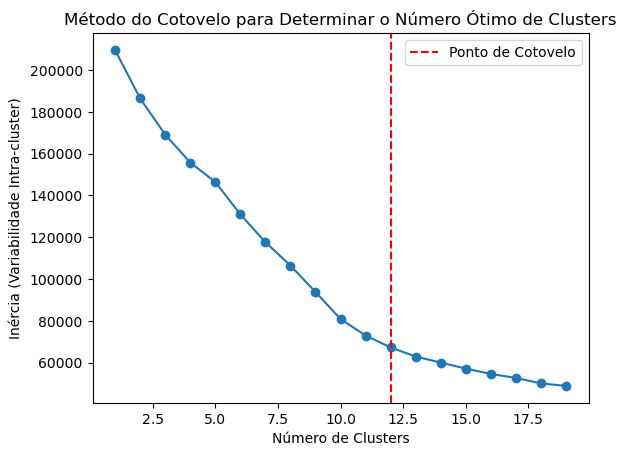

In [57]:
# Inicializa uma lista para armazenar as variabilidades intra-cluster para diferentes números de clusters
inertia = []

# Testa diferentes números de clusters (de 1 a 29) e calcula a variabilidade intra-cluster (inertia) para cada um
for k in range(1, 30):
    # Configura o modelo KMeans com o número atual de clusters e uma semente aleatória para reprodutibilidade
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Defina n_init explicitamente
    # Ajusta o modelo aos dados padronizados
    kmeans.fit(df_pad_scaled)
    # Armazena a variabilidade intra-cluster na lista
    inertia.append(kmeans.inertia_)

# Plota o gráfico do método do cotovelo
plt.plot(range(1, 30), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Variabilidade Intra-cluster)')
plt.title('Método do Cotovelo para Determinar o Número Ótimo de Clusters')

# Encontrar o índice do ponto de cotovelo
elbow_index = 11  
plt.axvline(x=elbow_index + 1, color='red', linestyle='--', label='Ponto de Cotovelo')  # +1 porque o índice começa em 0

plt.legend()
plt.show()



**Observando o gráfico do método do cotovelo acima, identificamos um ponto de inflexão que sugere uma melhor escolha para o número de clusters. Portanto, ao adotarmos essa quantidade, construiremos o modelo a seguir:**

## Avaliação de resultados

Avaliamos os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [58]:
# Configura o modelo KMeans com 4 clusters e uma semente aleatória para reprodutibilidade
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)

# Ajusta o modelo aos dados padronizados
kmeans.fit(df_pad_scaled)

# Adiciona a coluna 'grupo' ao DataFrame original 'df'
df['grupo'] = kmeans.labels_

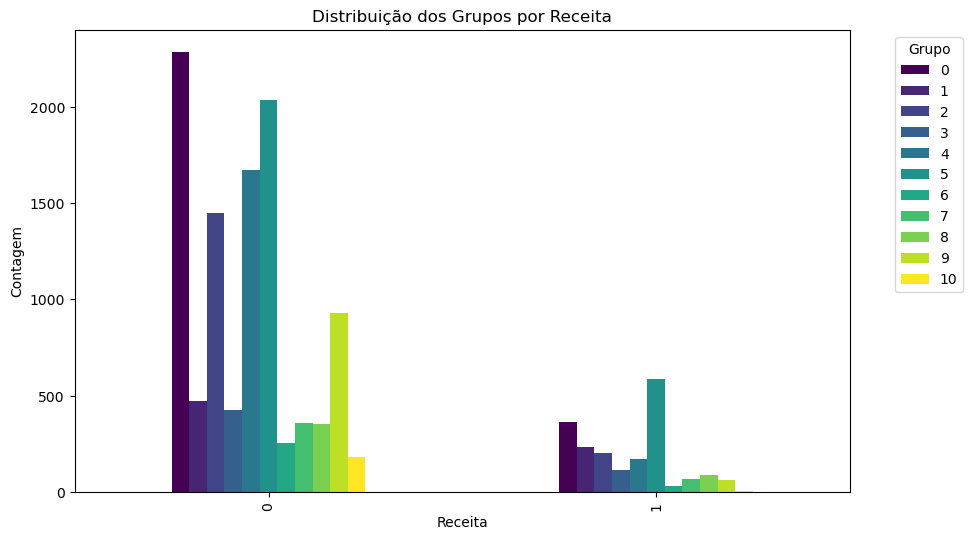

In [62]:
# Crosstab
crosstab_result = pd.crosstab(df['Revenue'], df['grupo'])

# Gráfico de barras agrupadas
crosstab_result.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Distribuição dos Grupos por Receita')
plt.xlabel('Receita')
plt.ylabel('Contagem')
plt.legend(title='Grupo', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Nesse gráfico vemos claramente que o grupo 5 tem uma maior aceitação em relação aos demais grupos.**